In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from deepshape.curves import *

In [5]:
def curve_reparametrization(c1, c2, num_layers, num_functions, transform="qmap", k=256, **kwargs):
    if transform.lower() == "qmap":
        q, r = Qmap(c1), Qmap(c2)
    elif transform.lower() == "srvt":
        q, r = SRVT(c1), SRVT(c2)
    else:
        raise ValueError("Transform should be 'qmap' or 'srvt'")
        
    RN = CurveReparametrizer(
            [SineSeries(num_functions) for _ in range(num_layers)]
    )
    optimizer = torch.optim.LBFGS(RN.parameters(), max_iter=200,
                                 line_search_fn="strong_wolfe")
    loss = CurveDistance(q, r, k=k)
    error = reparametrize(RN, loss, optimizer, 1, TimeLogger(), **kwargs)
    return error, RN

def create_convergence_dict(c0, c1, num_layer_list, num_function_list, parser=None, *args, **kwargs):
    if parser is None:
        parser = lambda x: x[0][-1]
    
    return {
        i: {
            j: parser(curve_reparametrization(c0, c1, i, j)) for j in num_function_list
        }
        for i in num_layer_list
    }


def depth_convergence(d):
    return {j: [d[i][j] for i in d] for j in list(d.values())[0]}


def width_convergence(d):
    return {i: [d[i][j] for j in list(d.values())[0]] for i in d}


def create_convergence_matrix(d):
    Eij = np.zeros((len(d), len(list(d.values())[0])))
    for i, num_layers in enumerate(d):
        for j, num_funcs in enumerate(d[num_layers]):
            Eij[i, j] = d[num_layers][num_funcs]
    return Eij


def plot_depth_convergence(d, ax=None, log=True):
    E = depth_convergence(d)
    N = list(width_convergence(d))

    if ax is None:
        fig, ax = plt.subplots()
        
    for num_funcs, error in E.items():
        if log:
            ax.semilogy(N, error, label=f"{num_funcs} functions")
        else:
            ax.plot(N, error, label=f"{num_funcs} functions")
    ax.set_xticks(N)
    return ax
    
    
def plot_width_convergence(d, ax=None, log=True):
    E = width_convergence(d)
    N = list(depth_convergence(d))
    
    if ax is None:
        fig, ax = plt.subplots()
        
    for num_layers, error in E.items():
        if log:
            ax.semilogy(N, error, label=f"{num_layers} layers")
        else:
            ax.plot(N, error, label=f"{num_layers} layers")
    ax.set_xticks(N)
    return ax

# Same Shape Comparison 

## Circle 

#### Qmap 


Finished training in 1.48733s


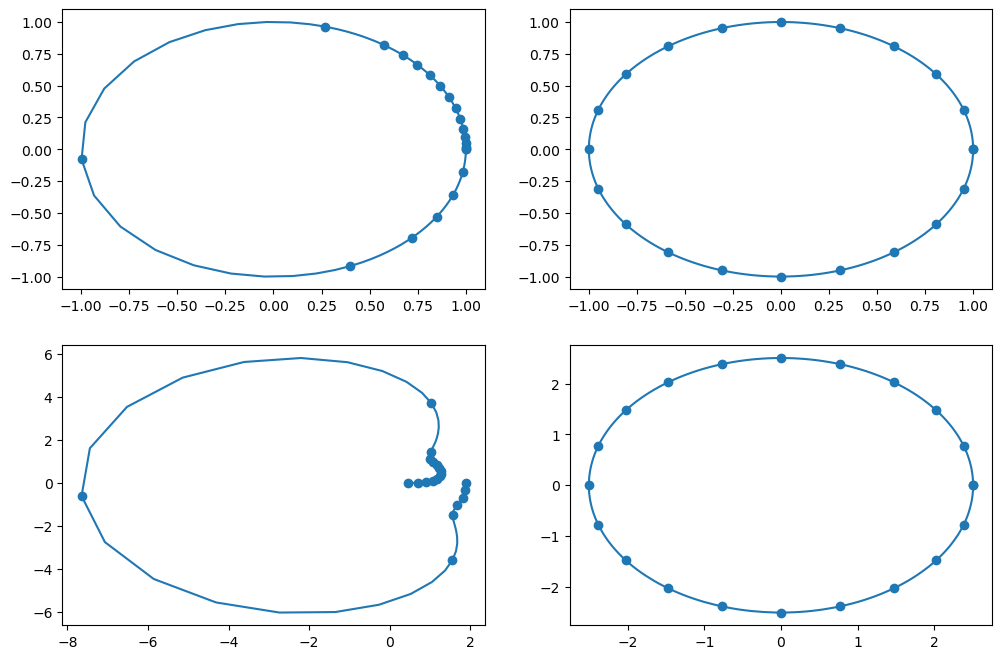

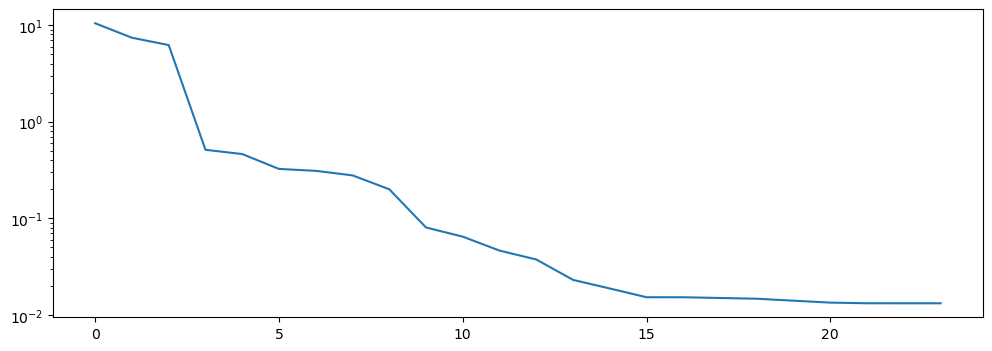

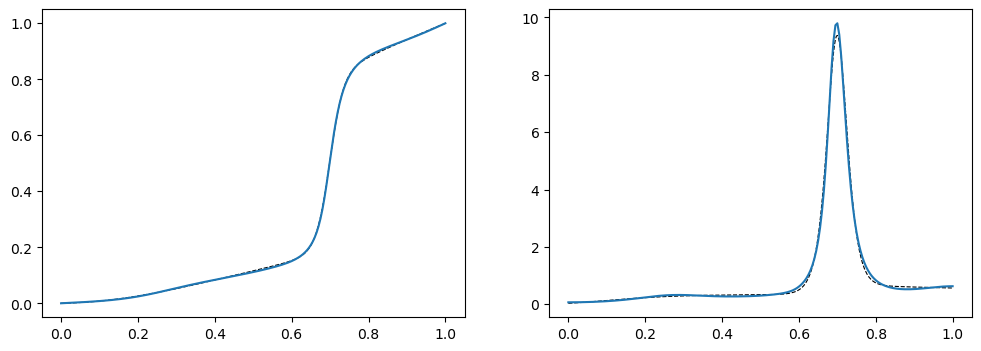

In [6]:
fig_path = "../figures/curves/circle"

g = QuadDiff().compose(LogStepDiff().compose(QuadDiff()))

# Define curves and transforms
c1 = Circle()
c0 = c1.compose(g)
q, r = Qmap(c0), Qmap(c1)


# Reparametrize and plot convergence
RN = CurveReparametrizer([SineSeries(5) for _ in range(5)])
optimizer = torch.optim.LBFGS(RN.parameters(), max_iter=100,
                              line_search_fn="strong_wolfe")
loss = CurveDistance(q, r, k=256)
error = reparametrize(RN, loss, optimizer, 1, TimeLogger())

# Plot curves and their transforms
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plot_curve(c0, dotpoints=21, ax=axes[0, 0])
plot_curve(c1, dotpoints=21, ax=axes[0, 1])
plot_curve(q, dotpoints=21, ax=axes[1, 0])
plot_curve(r, dotpoints=21, ax=axes[1, 1])
plt.show()


plt.figure(figsize=(12, 4))
plt.semilogy(error)
plt.show()


# Plot Diffeomorphism with derivative
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
plot_diffeomorphism(g, ax=ax1, c="k", lw=0.8, ls="--")
plot_diffeomorphism(RN, ax=ax1)
plot_derivative(g, ax=ax2, c="k", lw=0.8, ls="--")
plot_diffeomorphism(RN.derivative, ax=ax2)
plt.show()

#### SRVT 


Finished training in 0.36208s


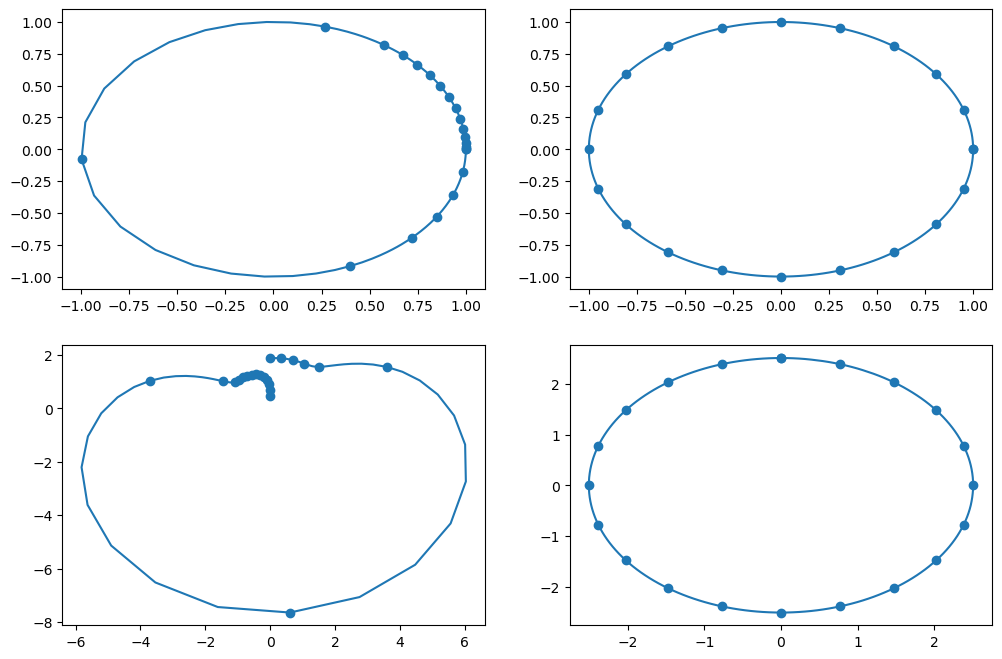

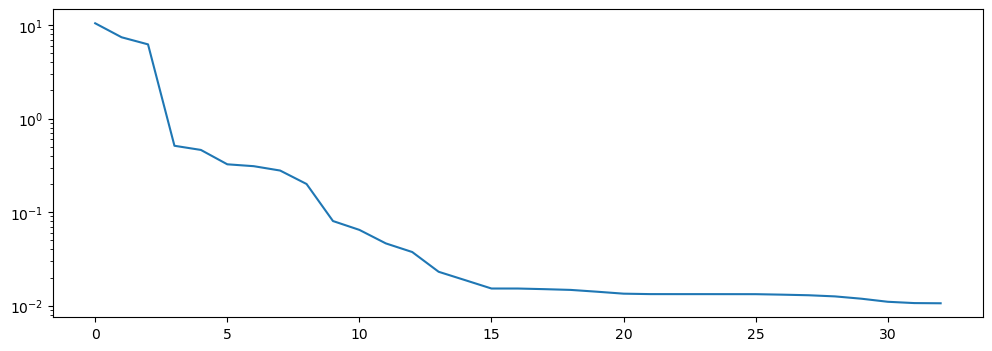

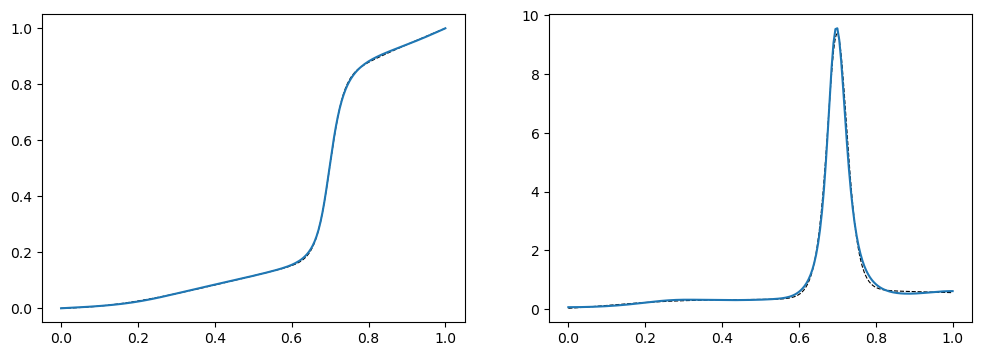

In [8]:
fig_path = "../figures/curves/circle"

g = QuadDiff().compose(LogStepDiff().compose(QuadDiff()))

# Define curves and transforms
c1 = Circle()
c0 = c1.compose(g)
q, r = SRVT(c0), SRVT(c1)


# Reparametrize and plot convergence
RN = CurveReparametrizer([SineSeries(5) for _ in range(5)])
optimizer = torch.optim.LBFGS(RN.parameters(), max_iter=100,
                              line_search_fn="strong_wolfe")
loss = CurveDistance(q, r, k=256)
error = reparametrize(RN, loss, optimizer, 1, TimeLogger())

# Plot curves and their transforms
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plot_curve(c0, dotpoints=21, ax=axes[0, 0])
plot_curve(c1, dotpoints=21, ax=axes[0, 1])
plot_curve(q, dotpoints=21, ax=axes[1, 0])
plot_curve(r, dotpoints=21, ax=axes[1, 1])
plt.show()


plt.figure(figsize=(12, 4))
plt.semilogy(error)
plt.show()


# Plot Diffeomorphism with derivative
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
plot_diffeomorphism(g, ax=ax1, c="k", lw=0.8, ls="--")
plot_diffeomorphism(RN, ax=ax1)
plot_derivative(g, ax=ax2, c="k", lw=0.8, ls="--")
plot_diffeomorphism(RN.derivative, ax=ax2)
plt.show()

### Depth Convergence Plots 

In [21]:
def plot_depth_convergence(d, ax=None, subset=None, log=True):
    E = depth_convergence(d)
    N = list(width_convergence(d))

    if ax is None:
        fig, ax = plt.subplots()

    for num_funcs, error in E.items():
        if num_funcs in subset or subset is None: 
            if log:
                ax.semilogy(N, error, label=f"{num_funcs} functions")
            else:
                ax.plot(N, error, label=f"{num_funcs} functions")
    ax.set_xticks(N)
    return ax

def plot_width_convergence(d, ax=None, subset=None, log=True):
    E = width_convergence(d)
    N = list(depth_convergence(d))

    if ax is None:
        fig, ax = plt.subplots()

    for num_layers, error in E.items():
        if num_layers in subset or subset is None: 
            if log:
                ax.semilogy(N, error, label=f"{num_layers} layers")
            else:
                ax.plot(N, error, label=f"{num_layers} layers")
    ax.set_xticks(N)
    return ax


In [ ]:
num_layers_list = list(range(1, 16))
num_functions_list = list(range(1, 16))
subset = [1, 3, 5, 7, 10, 15]
d = create_convergence_dict(c0, c1, num_layers_list, num_functions_list)

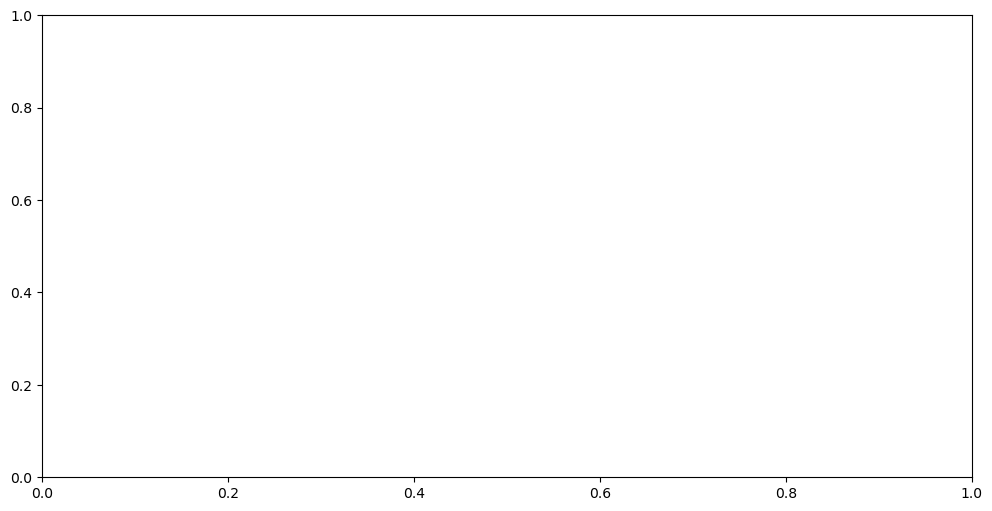

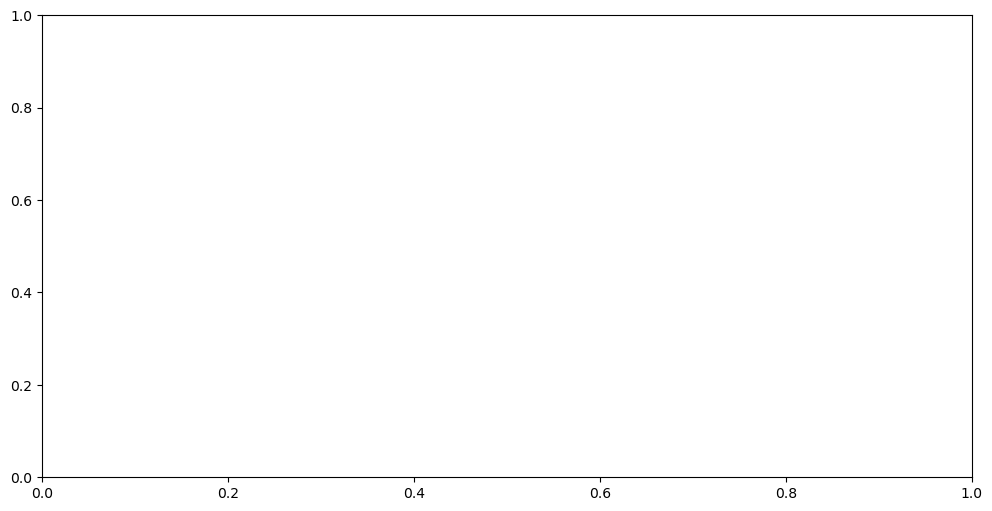

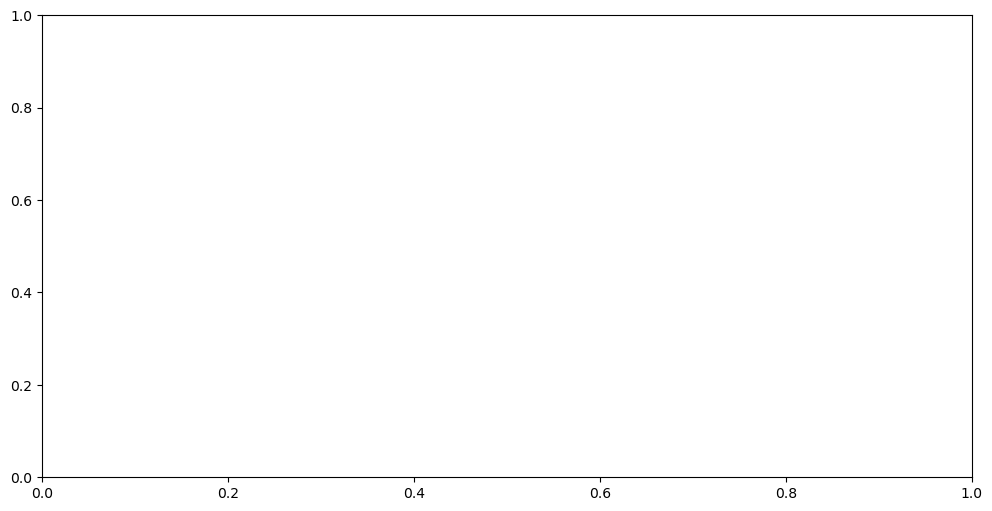

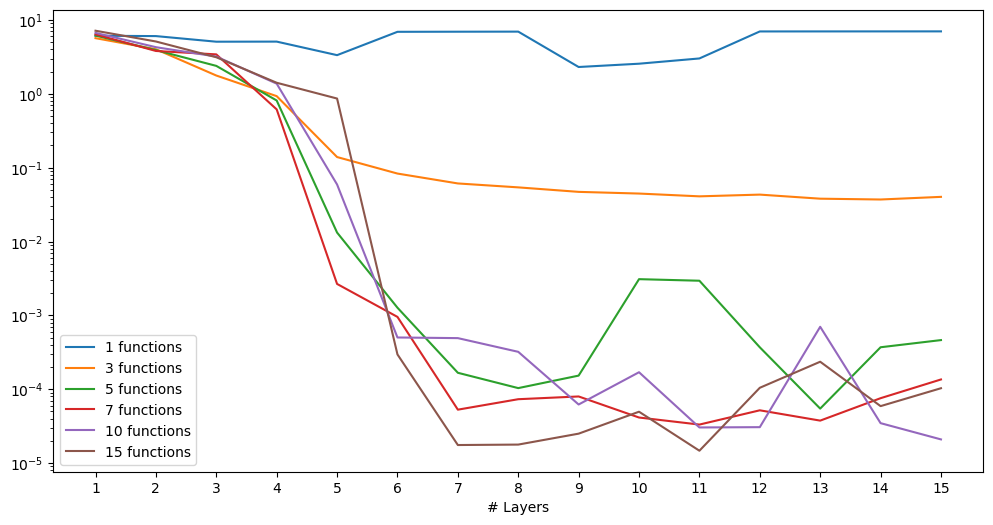

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
plot_depth_convergence(d, ax, subset=subset)
ax.legend()
ax.set_xlabel("# Layers")
fig.savefig(f"{fig_path}-convergence_num_layers.pdf")
plt.show()

### Width Convergence Plots 

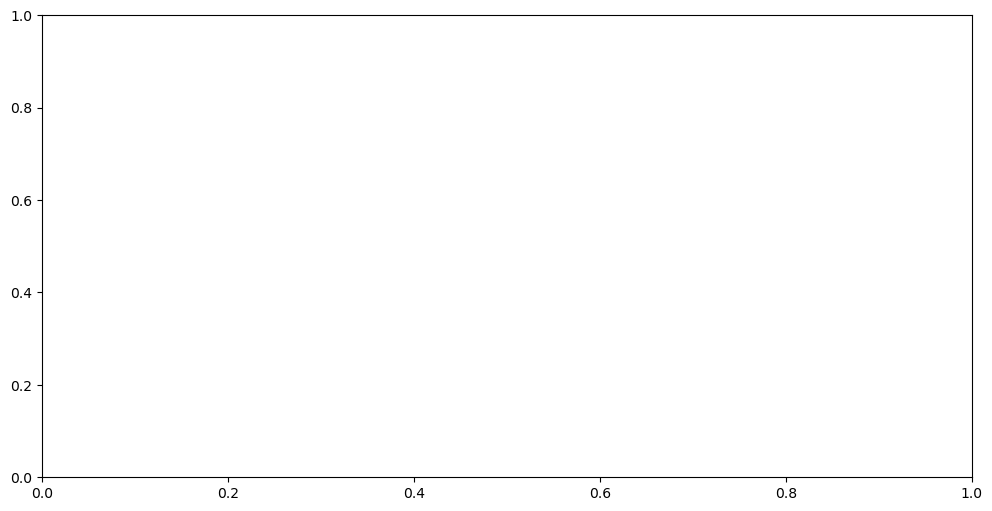

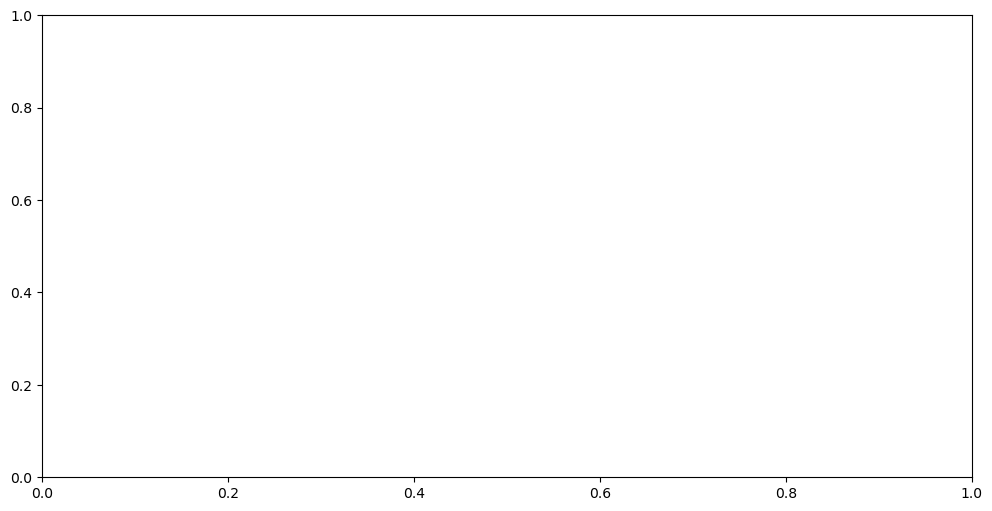

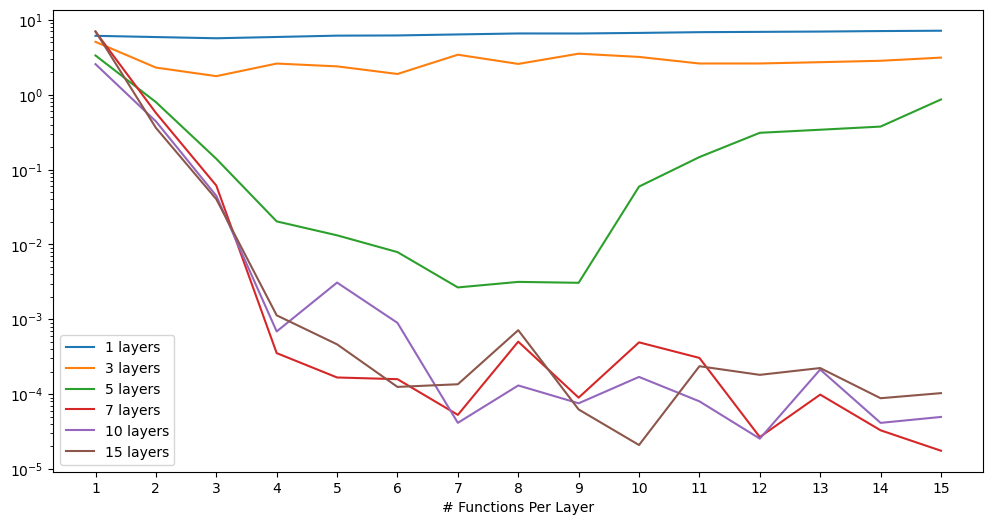

In [22]:
# num_functions_list = list(range(1, 21))
# num_layers_list = [1, 3, 5, 7, 10, 15]
# d = create_convergence_dict(c0, c1, num_layers_list, num_functions_list, projection_kwargs={"p": 1})

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
plot_width_convergence(d, ax, subset=subset)
ax.legend()
ax.set_xlabel("# Functions Per Layer")
fig.savefig(f"{fig_path}-convergence_num_funcs_per_layer.pdf")
plt.show()

## Infinity

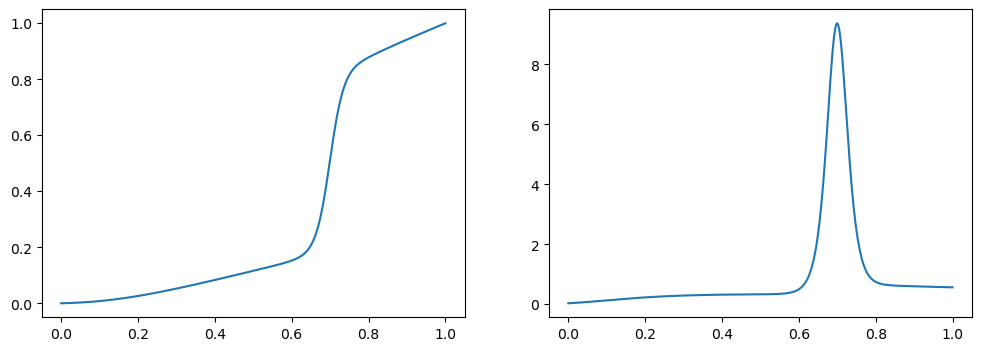

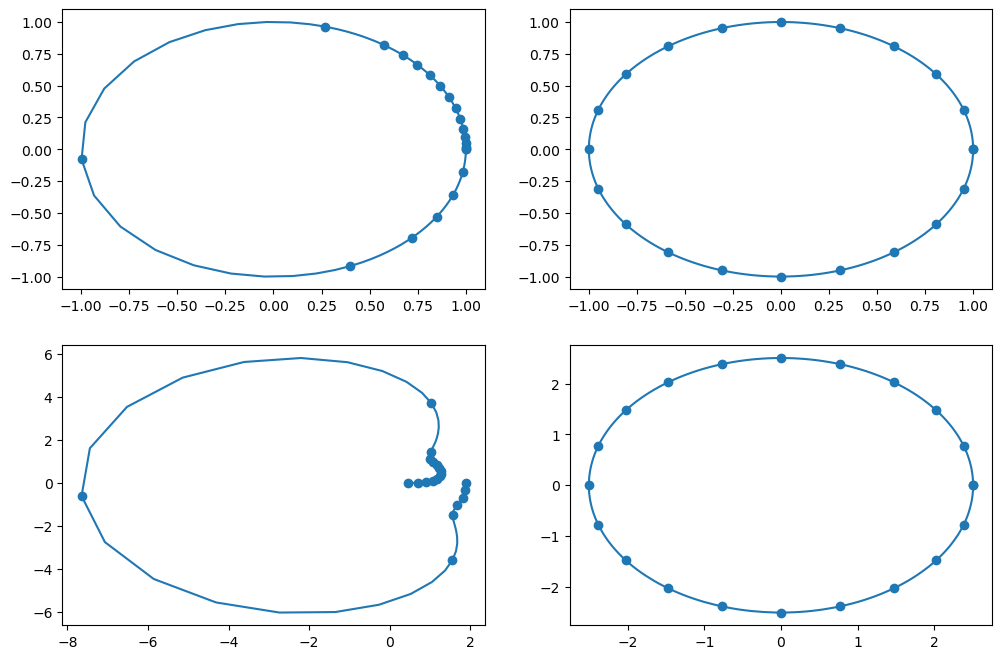


Finished training in 0.16061s


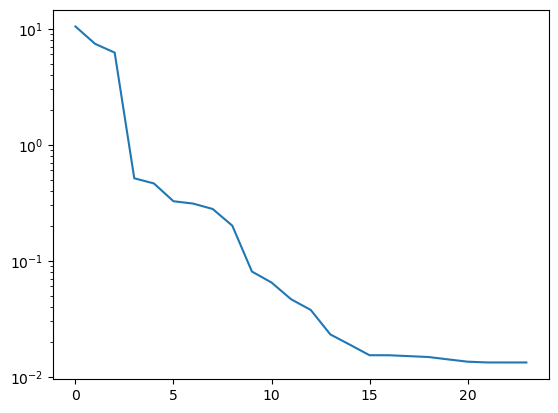

In [45]:
fig_path = "../figures/infinity"

g = QuadDiff().compose(LogStepDiff().compose(QuadDiff()))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
plot_diffeomorphism(g, ax=ax1)
plot_derivative(g, ax=ax2)
plt.show()

c1 = Circle()
c0 = c1.compose(g)

q, r = Qmap(c0), Qmap(c1)

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plot_curve(c0, dotpoints=21, ax=axes[0, 0])
plot_curve(c1, dotpoints=21, ax=axes[0, 1])
plot_curve(q, dotpoints=21, ax=axes[1, 0])
plot_curve(r, dotpoints=21, ax=axes[1, 1])
plt.show()

RN = CurveReparametrizer([SineSeries(5) for _ in range(5)])
optimizer = torch.optim.LBFGS(RN.parameters(), max_iter=100,
                              line_search_fn="strong_wolfe")
loss = CurveDistance(q, r, k=256)
error = reparametrize(RN, loss, optimizer, 1, TimeLogger())
plt.semilogy(error)
plt.show()


# Plot curves and their transforms
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plot_curve(c0, dotpoints=21, ax=axes[0, 0])
plot_curve(c1, dotpoints=21, ax=axes[0, 1])
plot_curve(q, dotpoints=21, ax=axes[1, 0])
plot_curve(r, dotpoints=21, ax=axes[1, 1])
plt.show()


# Reparametrize and plot convergence
RN = CurveReparametrizer([SineSeries(2) for _ in range(1)])
optimizer = torch.optim.LBFGS(RN.parameters(), max_iter=100,
                              line_search_fn="strong_wolfe")
loss = CurveDistance(q, r, k=256)
error = reparametrize(RN, loss, optimizer, 1, TimeLogger())
plt.semilogy(error)
plt.show()


# Plot Diffeomorphism with derivative
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
plot_diffeomorphism(g, ax=ax1, c="k", lw=0.8, ls="--")
plot_diffeomorphism(RN, ax=ax1)
plot_derivative(g, ax=ax2, c="k", lw=0.8, ls="--")
plot_diffeomorphism(RN.derivative, ax=ax2)
plt.show()

### Depth Convergence Plots 

In [57]:
num_layers_list = list(range(1, 21))
num_functions_list = [1, 3, 5, 7, 10, 15]
d = create_convergence_dict(c0, c1, num_layers_list, num_functions_list)


Finished training in 0.02468s

Finished training in 0.07723s

Finished training in 0.06071s

Finished training in 0.24282s

Finished training in 0.14668s

Finished training in 0.04589s

Finished training in 0.04633s

Finished training in 0.04635s

Finished training in 0.02396s

Finished training in 0.39354s

Finished training in 0.38277s

Finished training in 0.38265s

Finished training in 0.09162s

Finished training in 0.06296s

Finished training in 0.04922s

Finished training in 0.03509s

Finished training in 0.06547s

Finished training in 0.06522s

Finished training in 0.08147s

Finished training in 0.11455s

Finished training in 0.04946s

Finished training in 0.17304s

Finished training in 0.07380s

Finished training in 0.04392s

Finished training in 0.21496s

Finished training in 0.20692s

Finished training in 0.07443s

Finished training in 0.07746s

Finished training in 0.10176s

Finished training in 0.09067s

Finished training in 0.02354s

Finished training in 0.20699s

Finishe

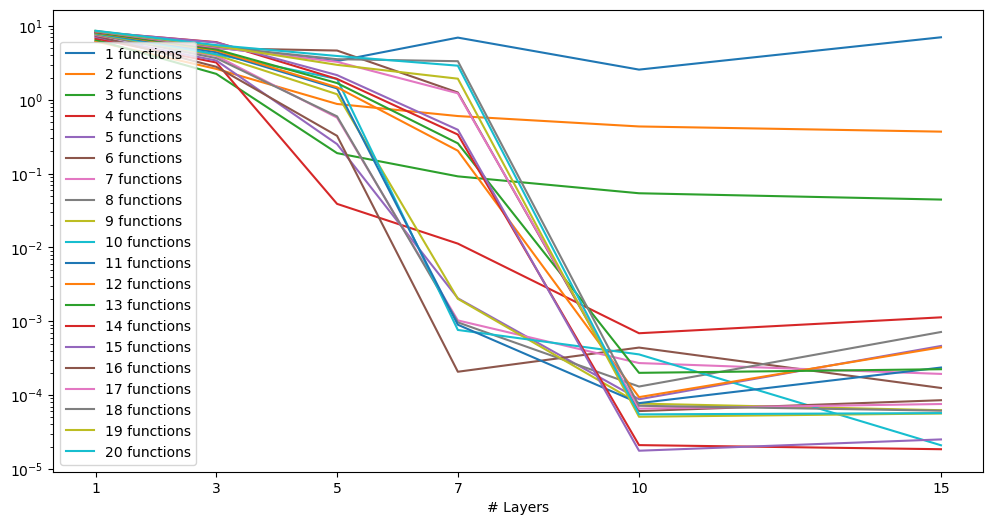

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
plot_depth_convergence(d, ax)
ax.legend()
ax.set_xlabel("# Layers")
fig.savefig(f"{fig_path}-convergence_num_layers.pdf")
plt.show()

### Width Convergence Plots 

In [74]:
num_functions_list = list(range(1, 21))
num_layers_list = [1, 3, 5, 7, 10, 15]
d = create_convergence_dict(c0, c1, num_layers_list, num_functions_list, projection_kwargs={"p": 2})


Finished training in 0.02509s

Finished training in 0.05626s

Finished training in 0.03043s

Finished training in 0.03406s

Finished training in 0.02355s

Finished training in 0.02558s

Finished training in 0.04444s

Finished training in 0.02855s

Finished training in 0.02639s

Finished training in 0.05625s

Finished training in 0.02567s

Finished training in 0.04281s

Finished training in 0.07646s

Finished training in 0.03874s

Finished training in 0.04727s

Finished training in 0.04553s

Finished training in 0.05677s

Finished training in 0.04212s

Finished training in 0.20288s

Finished training in 0.03158s

Finished training in 0.09225s

Finished training in 0.07747s

Finished training in 0.26990s

Finished training in 0.05106s

Finished training in 0.06851s

Finished training in 0.12044s

Finished training in 0.06088s

Finished training in 0.05222s

Finished training in 0.07696s

Finished training in 0.03923s

Finished training in 0.10702s

Finished training in 0.08838s

Finishe

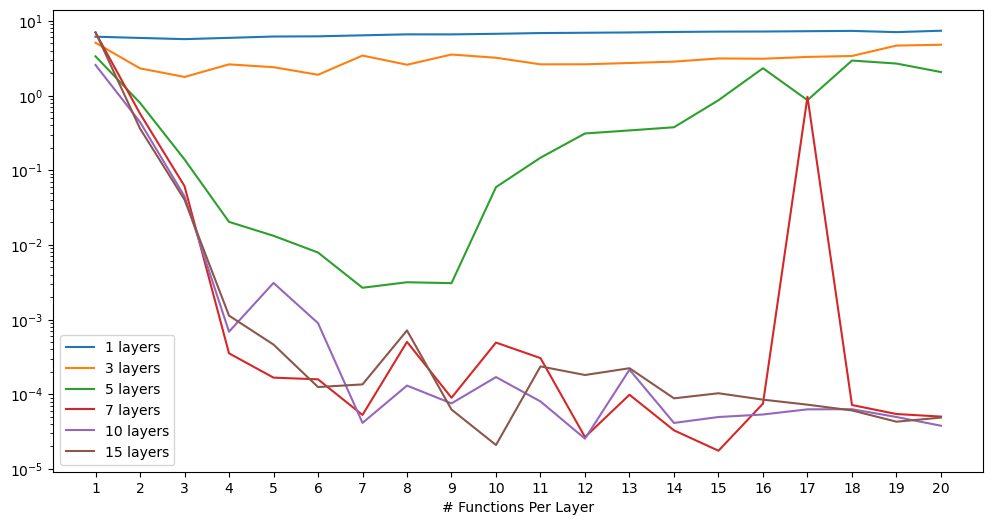

In [75]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
plot_width_convergence(d, ax)
ax.legend()
ax.set_xlabel("# Functions Per Layer")
fig.savefig(f"{fig_path}/convergence_num_funcs_per_layer.pdf")
plt.show()

In [64]:
np.array([[dij for dij in di.values()] for di in d.values()]).min()

1.7649306755629368e-05

In [70]:
np.array([[dij for dij in di.values()] for di in d.values()]).min()

1.7555104932398535e-05

Curve:Circle


<Figure size 640x480 with 0 Axes>

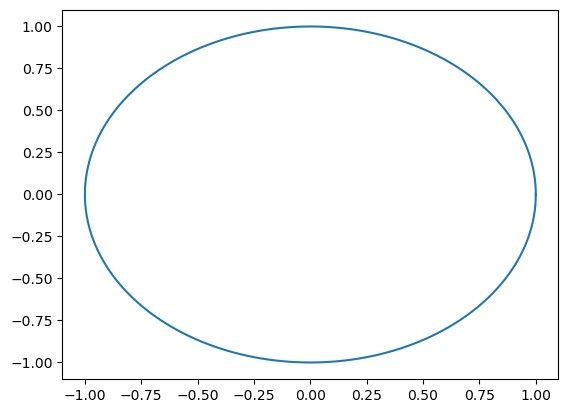

In [81]:
curve = input("Curve:")
c3 = eval(f"{curve}()")

plt.figure()
plot_curve(c3)
plt.show()

# Different Shape Comparison

## Qmaps 

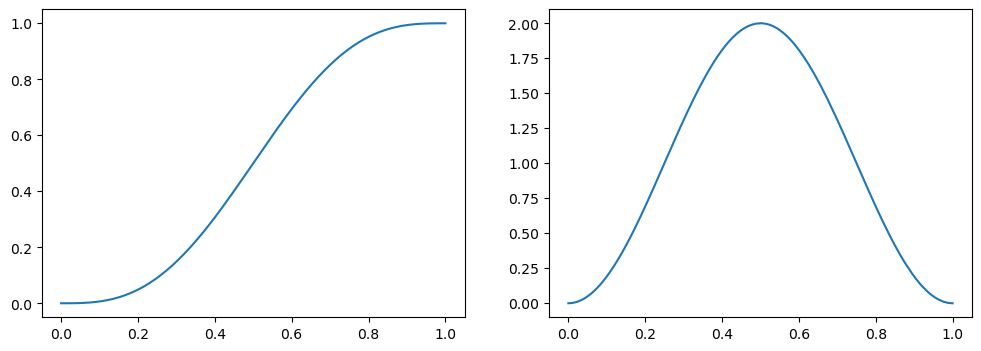

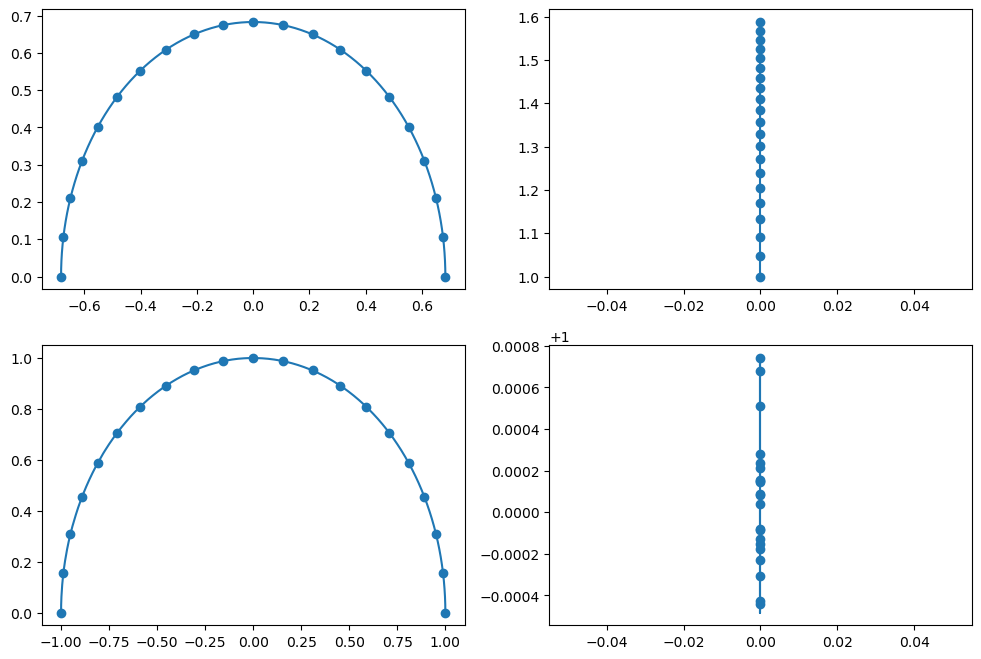


Finished training in 0.09280s


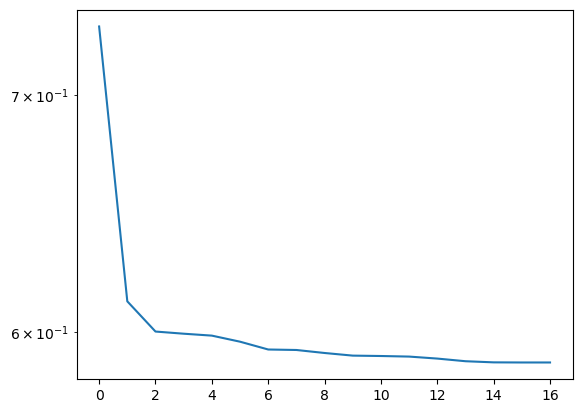

In [12]:
fig_path = "../figures/curves/same-shape-qmaps"

g = OptimalCircleLine()

# Plot Diffeomorphism with derivative
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
plot_diffeomorphism(g, ax=ax1)
plot_derivative(g, ax=ax2)
plt.show()

# Define curves and transforms
c0 = HalfCircle("qmap")
c1 = Line("qmap")
q, r = Qmap(c0), Qmap(c1)
distance = CurveDistance(q, Qmap(c1.compose(g)), k=256)(CurveReparametrizer([]))

# Plot curves and their transforms
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plot_curve(c0, dotpoints=21, ax=axes[0, 0])
plot_curve(c1, dotpoints=21, ax=axes[0, 1])
plot_curve(q, dotpoints=21, ax=axes[1, 0])
plot_curve(r, dotpoints=21, ax=axes[1, 1])
plt.show()


# Reparametrize and plot convergence
RN = CurveReparametrizer([SineSeries(5) for _ in range(5)])
optimizer = torch.optim.LBFGS(RN.parameters(), max_iter=100,
                              line_search_fn="strong_wolfe")
loss = CurveDistance(q, r, k=256)
error = reparametrize(RN, loss, optimizer, 1, TimeLogger())
plt.semilogy(error)
plt.show()

### Depth Convergence Plots 

In [13]:
num_layers_list = list(range(1, 21))
num_functions_list = [1, 3, 5, 7, 10, 15]
d = create_convergence_dict(c0, c1, num_layers_list, num_functions_list,
                           parser=lambda x: x[0][-1] - distance)

[Iter     1] loss: 0.731802

Finished training in 0.00215s
[Iter     1] loss: 0.731802

Finished training in 0.03141s
[Iter     1] loss: 0.731802

Finished training in 0.08252s
[Iter     1] loss: 0.731802

Finished training in 0.06837s
[Iter     1] loss: 0.731802

Finished training in 0.06749s
[Iter     1] loss: 0.731802

Finished training in 0.04885s
[Iter     1] loss: 0.731802

Finished training in 0.00178s
[Iter     1] loss: 0.731802

Finished training in 0.03161s
[Iter     1] loss: 0.731802
[Iter    11] loss: 0.590978

Finished training in 0.05564s
[Iter     1] loss: 0.731802
[Iter    11] loss: 0.587684

Finished training in 0.04929s
[Iter     1] loss: 0.731802
[Iter    11] loss: 0.587657

Finished training in 0.05734s
[Iter     1] loss: 0.731802
[Iter    11] loss: 0.587505

Finished training in 0.04765s
[Iter     1] loss: 0.731802

Finished training in 0.00238s
[Iter     1] loss: 0.731802

Finished training in 0.03575s
[Iter     1] loss: 0.731802
[Iter    11] loss: 0.588308

Finis


Finished training in 0.04370s
[Iter     1] loss: 0.731802
[Iter    11] loss: 0.593311
[Iter    21] loss: 0.591768
[Iter    31] loss: 0.589763
[Iter    41] loss: 0.588021

Finished training in 0.41409s
[Iter     1] loss: 0.731802
[Iter    11] loss: 0.591199
[Iter    21] loss: 0.589116
[Iter    31] loss: 0.588616
[Iter    41] loss: 0.587984

Finished training in 0.36625s
[Iter     1] loss: 0.731802
[Iter    11] loss: 0.588892

Finished training in 0.13183s
[Iter     1] loss: 0.731802
[Iter    11] loss: 0.588144

Finished training in 0.12123s
[Iter     1] loss: 0.731802

Finished training in 0.02290s
[Iter     1] loss: 0.731802
[Iter    11] loss: 0.614442
[Iter    21] loss: 0.597902

Finished training in 0.49824s
[Iter     1] loss: 0.731802
[Iter    11] loss: 0.593519
[Iter    21] loss: 0.591788

Finished training in 0.19030s
[Iter     1] loss: 0.731802
[Iter    11] loss: 0.591182
[Iter    21] loss: 0.589082

Finished training in 0.19798s
[Iter     1] loss: 0.731802
[Iter    11] loss: 0.

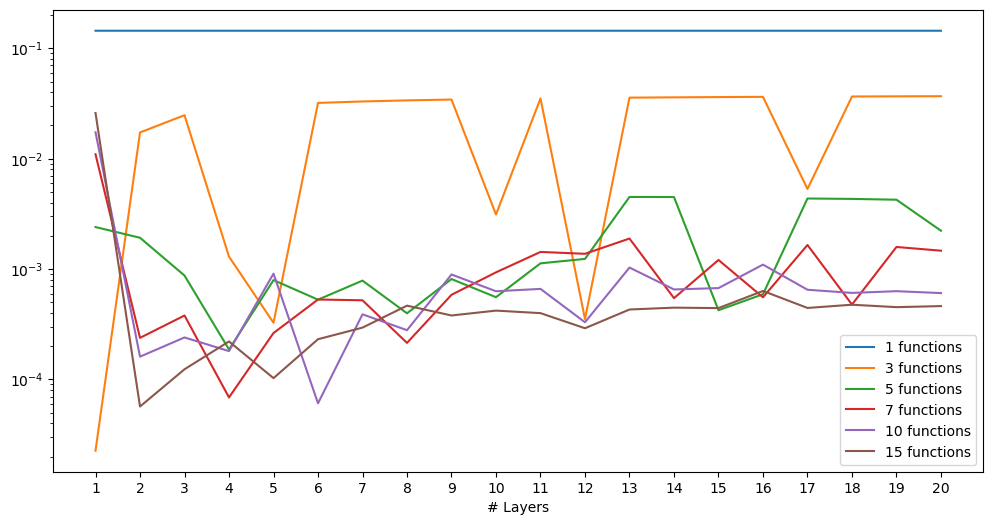

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
plot_depth_convergence(d, ax)
ax.legend()
ax.set_xlabel("# Layers")
fig.savefig(f"{fig_path}-convergence_num_layers.pdf")
plt.show()

### Width Convergence Plots 

In [15]:
num_functions_list = list(range(1, 21))
num_layers_list = [1, 3, 5, 7, 10, 15]
d = create_convergence_dict(c0, c1, num_layers_list, num_functions_list,
                           parser=lambda x: x[0][-1] - distance)

[Iter     1] loss: 0.731802

Finished training in 0.00227s
[Iter     1] loss: 0.731802

Finished training in 0.03755s
[Iter     1] loss: 0.731802

Finished training in 0.02350s
[Iter     1] loss: 0.731802

Finished training in 0.03170s
[Iter     1] loss: 0.731802

Finished training in 0.07958s
[Iter     1] loss: 0.731802

Finished training in 0.08478s
[Iter     1] loss: 0.731802

Finished training in 0.06859s
[Iter     1] loss: 0.731802

Finished training in 0.06943s
[Iter     1] loss: 0.731802

Finished training in 0.04730s
[Iter     1] loss: 0.731802

Finished training in 0.07393s
[Iter     1] loss: 0.731802

Finished training in 0.03475s
[Iter     1] loss: 0.731802

Finished training in 0.03732s
[Iter     1] loss: 0.731802

Finished training in 0.11495s
[Iter     1] loss: 0.731802

Finished training in 0.04014s
[Iter     1] loss: 0.731802

Finished training in 0.05056s
[Iter     1] loss: 0.731802

Finished training in 0.10637s
[Iter     1] loss: 0.731802

Finished training in 0.0545

[Iter    11] loss: 0.588347
[Iter    21] loss: 0.587936

Finished training in 0.12005s
[Iter     1] loss: 0.731802
[Iter    11] loss: 0.588088
[Iter    21] loss: 0.587829

Finished training in 0.12949s
[Iter     1] loss: 0.731802
[Iter    11] loss: 0.588074

Finished training in 0.10315s
[Iter     1] loss: 0.731802
[Iter    11] loss: 0.587954

Finished training in 0.16304s
[Iter     1] loss: 0.731802
[Iter    11] loss: 0.587989
[Iter    21] loss: 0.587746

Finished training in 0.20390s
[Iter     1] loss: 0.731802

Finished training in 0.06135s
[Iter     1] loss: 0.731802
[Iter    11] loss: 0.587898

Finished training in 0.10092s
[Iter     1] loss: 0.731802
[Iter    11] loss: 0.587760

Finished training in 0.08752s
[Iter     1] loss: 0.731802

Finished training in 0.02930s
[Iter     1] loss: 0.731802

Finished training in 0.07780s
[Iter     1] loss: 0.731802

Finished training in 0.04677s
[Iter     1] loss: 0.731802
[Iter    11] loss: 0.593043

Finished training in 0.17125s
[Iter     1]

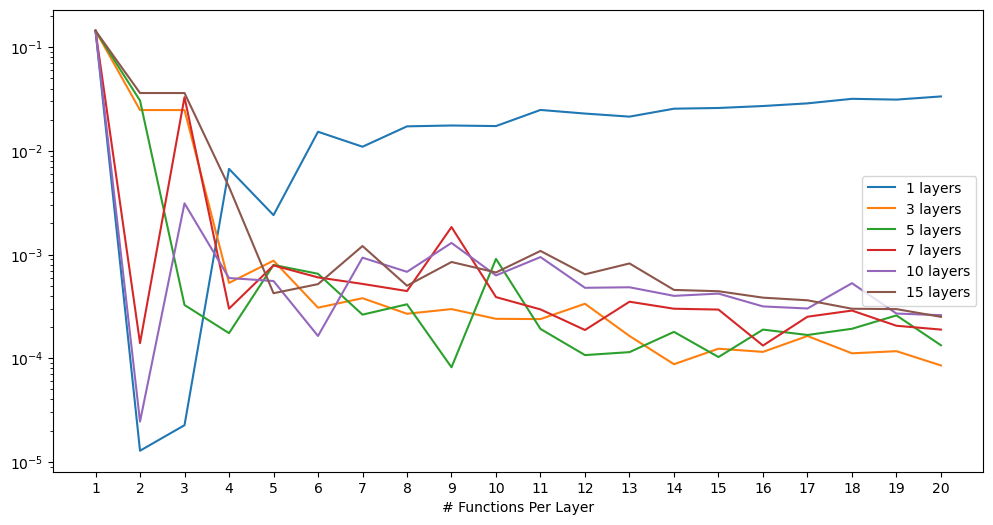

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
plot_width_convergence(d, ax)
ax.legend()
ax.set_xlabel("# Functions Per Layer")
fig.savefig(f"{fig_path}-convergence_num_funcs_per_layer.pdf")
plt.show()

## SRVT 

In [26]:
X = col_linspace(0, 1, 11)

In [25]:
X.size()

torch.Size([11, 1])

In [27]:
r(X).size()

tensor([[1.0000],
        [1.0000],
        [1.0000],
        [0.9999],
        [0.9999],
        [1.0000],
        [1.0002],
        [1.0002],
        [1.0002],
        [1.0002],
        [1.0002]])


torch.Size([11, 2])

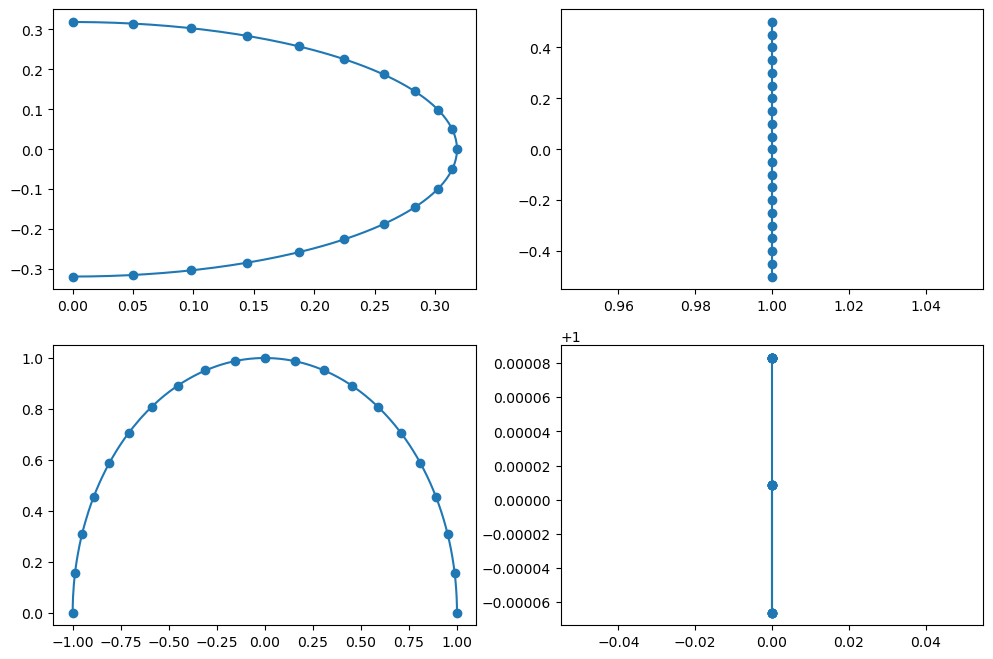


Finished training in 0.03522s


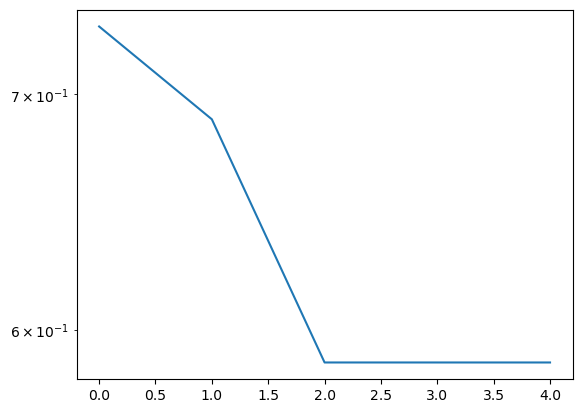

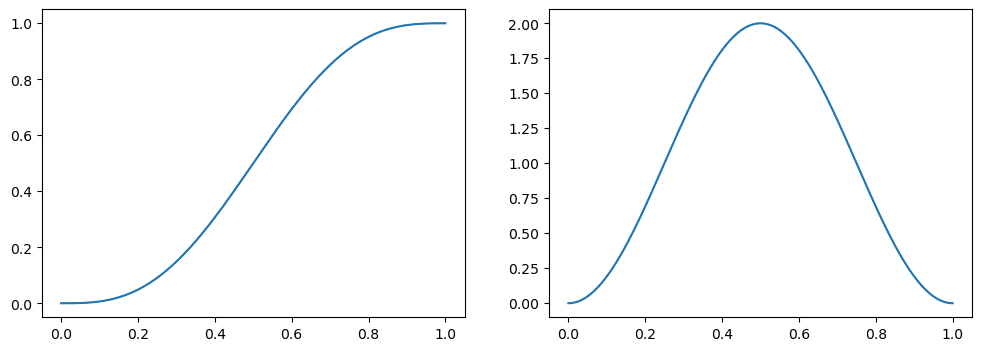

In [42]:
fig_path = "../figures/curves/same-shape-srvt"

g = OptimalCircleLine()

# Define curves and transforms
c0 = HalfCircle("srvt")
c1 = Line("srvt")
q, r = SRVT(c0), SRVT(c1)
distance = CurveDistance(q, SRVT(c1.compose(g)), k=256)(CurveReparametrizer([]))

# Plot curves and their transforms
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
plot_curve(c0, dotpoints=21, ax=axes[0, 0])
plot_curve(c1, dotpoints=21, ax=axes[0, 1])
plot_curve(q, dotpoints=21, ax=axes[1, 0])
plot_curve(r, dotpoints=21, ax=axes[1, 1])
plt.show()


# Reparametrize and plot convergence
RN = CurveReparametrizer([SineSeries(2) for _ in range(1)])
optimizer = torch.optim.LBFGS(RN.parameters(), max_iter=100,
                              line_search_fn="strong_wolfe")
loss = CurveDistance(q, r, k=256)
error = reparametrize(RN, loss, optimizer, 1, TimeLogger())
plt.semilogy(error)
plt.show()


# Plot Diffeomorphism with derivative
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
plot_diffeomorphism(g, ax=ax1, c="k", lw=0.8, ls="--")
plot_diffeomorphism(RN, ax=ax1)
plot_derivative(g, ax=ax2, c="k", lw=0.8, ls="--")
plot_diffeomorphism(RN.derivative, ax=ax2)
plt.show()

### Depth Convergence Plots 

In [43]:
num_layers_list = list(range(1, 21))
num_functions_list = [3, 5, 7, 10, 15]
d = create_convergence_dict(c0, c1, num_layers_list, num_functions_list,
                           parser=lambda x: x[0][-1] - distance, transform="srvt")

[Iter     1] loss: 0.651897

Finished training in 0.01573s
[Iter     1] loss: 0.651897

Finished training in 0.02088s
[Iter     1] loss: 0.651897
[Iter    11] loss: 0.615619

Finished training in 0.03318s
[Iter     1] loss: 0.651897
[Iter    11] loss: 0.615530

Finished training in 0.02865s
[Iter     1] loss: 0.651897
[Iter    11] loss: 0.615480

Finished training in 0.01934s
[Iter     1] loss: 0.651897

Finished training in 0.01249s
[Iter     1] loss: 0.651897
[Iter    11] loss: 0.615673

Finished training in 0.04108s
[Iter     1] loss: 0.651897
[Iter    11] loss: 0.615587

Finished training in 0.03065s
[Iter     1] loss: 0.651897
[Iter    11] loss: 0.615548

Finished training in 0.03898s
[Iter     1] loss: 0.651897
[Iter    11] loss: 0.615508

Finished training in 0.04054s
[Iter     1] loss: 0.651897

Finished training in 0.01248s
[Iter     1] loss: 0.651897
[Iter    11] loss: 0.615743

Finished training in 0.03806s
[Iter     1] loss: 0.651897
[Iter    11] loss: 0.615679

Finished tr

[Iter    11] loss: 0.615577
[Iter    21] loss: 0.615531

Finished training in 0.26507s


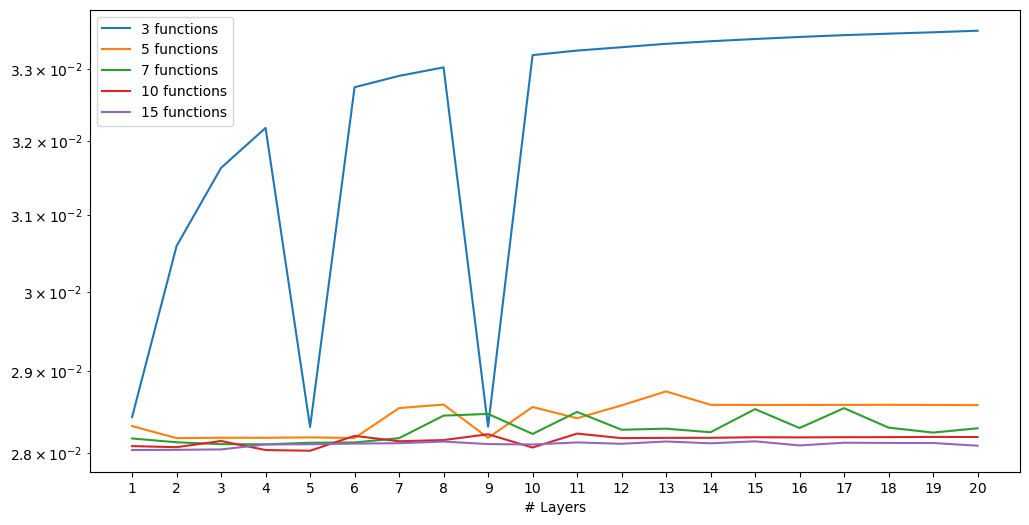

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
plot_depth_convergence(d, ax)
ax.legend()
ax.set_xlabel("# Layers")
fig.savefig(f"{fig_path}-convergence_num_layers.pdf")
plt.show()

### Width Convergence Plots 

In [40]:
num_functions_list = list(range(2, 21))
num_layers_list = [3, 5, 7, 10, 15]
d = create_convergence_dict(c0, c1, num_layers_list, num_functions_list,
                           parser=lambda x: x[0][-1] - distance, transform="srvt")

[Iter     1] loss: 0.651897
[Iter    11] loss: 0.616877
[Iter    21] loss: 0.615836

Finished training in 0.06200s
[Iter     1] loss: 0.651897

Finished training in 0.01326s
[Iter     1] loss: 0.651897
[Iter    11] loss: 0.615753
[Iter    21] loss: 0.615624

Finished training in 0.04432s
[Iter     1] loss: 0.651897
[Iter    11] loss: 0.615743

Finished training in 0.03920s
[Iter     1] loss: 0.651897
[Iter    11] loss: 0.615674

Finished training in 0.06731s
[Iter     1] loss: 0.651897
[Iter    11] loss: 0.615679

Finished training in 0.03943s
[Iter     1] loss: 0.651897
[Iter    11] loss: 0.615620

Finished training in 0.05231s
[Iter     1] loss: 0.651897
[Iter    11] loss: 0.615617

Finished training in 0.05905s
[Iter     1] loss: 0.651897
[Iter    11] loss: 0.615588

Finished training in 0.02621s
[Iter     1] loss: 0.651897
[Iter    11] loss: 0.615587

Finished training in 0.04397s
[Iter     1] loss: 0.651897
[Iter    11] loss: 0.615549

Finished training in 0.04332s
[Iter     1] lo

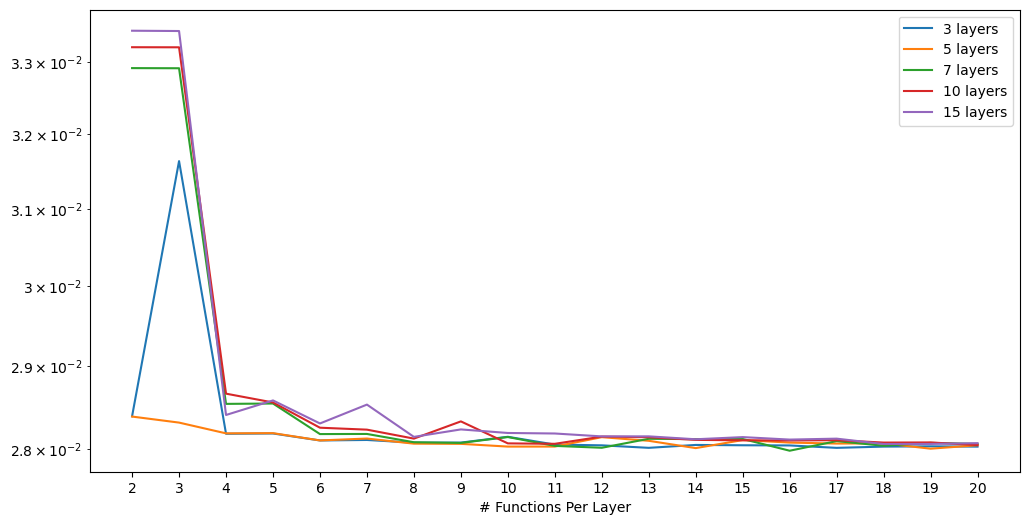

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
plot_width_convergence(d, ax)
ax.legend()
ax.set_xlabel("# Functions Per Layer")
fig.savefig(f"{fig_path}-convergence_num_funcs_per_layer.pdf")
plt.show()